In [1]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
path = "/Users/sreevathsadb/Masters/Project/Data/"
import plotly.express as px
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_rows', 17544) 
%matplotlib inline

# Configuring plotting visual and sizes
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

In [2]:
path = "/Users/sreevathsadb/Masters/Project/Data/"
path = path + 'dublin_bikes/' # use your path
#file_paths = glob.glob(path + "20*")
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018','2019', '2020',
       '2021', '2022']
selected = ['2013', '2014', '2015', '2016', '2017', '2018']

data = []
for i in range(0,len(selected)):
    #print(path+str(pre_post_covid[i])+'.csv')
    temp_data = pd.read_csv(path+str(selected[i])+'.csv', index_col=None, header=0)
    data.append(temp_data)
data = pd.concat(data, axis=0, ignore_index=True)
data.shape

(25812447, 22)

In [3]:
#(37470767, 17)
data.drop_duplicates(keep= 'first',inplace=True)
data.shape

(25812447, 22)

In [4]:
len(data['id'].unique())

109

In [5]:
#remove incorrect/bad samples
data = data.drop(data[(data['available_bike_stands'] == 0) & (data['available_bikes'] == 0)].index)
data = data.drop(data[(data['available_bike_stands'] + data['available_bikes']) != data['total_bike_stands']].index)
data.shape

(19139452, 22)

In [6]:
len(data['id'].unique())

109

In [7]:
conditions = [
    (data['weekday'] == "Saturday"),
    (data['weekday'] == "Sunday"),
    ]
values = ["Saturday", "Sunday"]
data['day_type']  = np.select(conditions, values,default="Weekday")

In [8]:
conditions = [
    (data['hour'] < 6),
    (data['hour'] < 11),
    (data['hour'] < 16),
    (data['hour'] < 20),
    (data['hour'] <= 23)
    ]
values = ["Overnight ", "6AM-10AM ", "11AM-3PM ","4PM-7PM ","8PM-11PM "]
data['classified_time'] = np.select(conditions, values,default="Overnight ")
data['cluster_group'] = data['classified_time'] + data['day_type']

In [9]:
merged_data = data
# identify bike arrivals and bike departures
merged_data['bike_arr_dep'] = merged_data.groupby('id')['available_bike_stands'].diff(-1)
merged_data['bike_arr'] = np.where(merged_data['bike_arr_dep'] > 0, merged_data['bike_arr_dep'], 0)
merged_data['bike_dep'] = np.where(merged_data['bike_arr_dep'] < 0, merged_data['bike_arr_dep'], 0)
#merged_data['bike_activity_type'] = np.where(abs(merged_data['bike_arr_dep']) >= 10, "rebalancing", "rental")
merged_data['interactions'] = abs(merged_data['bike_arr']) + abs(merged_data['bike_dep'])

In [10]:
null_data = merged_data[merged_data.isnull().any(axis=1)]
len(null_data)

109

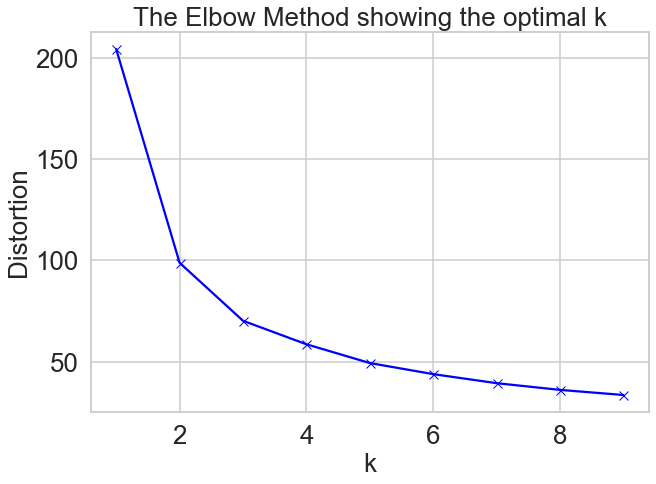

In [11]:
#group data into clusters
clustering_df = merged_data[['id', 'name', 'latitude', 'longitude', 'day_type', 'classified_time', 'interactions','cluster_group']]
clustering_df = clustering_df.groupby(['id', 'name', 'latitude', 'longitude', 'cluster_group'],as_index=False)['interactions'].mean()
clustering_df  = clustering_df.set_index('id')
#pivot dataframe for clustering
clustering_df = clustering_df.pivot_table(index= ['name', 'id','latitude', 'longitude'] , columns=['cluster_group'], values='interactions')
clustering_df  = clustering_df.reset_index()
clustering_df  = clustering_df.set_index('name')
clustering_df = clustering_df.apply(lambda x: x.fillna(x.mean()),axis=0)

distortions = []
K = range(1,10)
X = np.array(clustering_df.drop(['id', 'latitude', 'longitude'], 1).astype(float))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#clustering algo
X = np.array(clustering_df.drop(['id', 'latitude', 'longitude'], 1).astype(float))
KM = KMeans(n_clusters=3) 
KM.fit(X)
clusters = KM.predict(X)

locations = clustering_df
locations['Cluster'] = clusters
locations = locations.reset_index()

locations.columns
col_list = ['11AM-3PM Saturday','11AM-3PM Sunday', '11AM-3PM Weekday', '4PM-7PM Saturday',
       '4PM-7PM Sunday', '4PM-7PM Weekday', '6AM-10AM Saturday','6AM-10AM Sunday', 
       '6AM-10AM Weekday', '8PM-11PM Saturday','8PM-11PM Sunday', '8PM-11PM Weekday', 
       'Overnight Saturday','Overnight Sunday', 'Overnight Weekday']
locations['order'] = locations[col_list].mean(axis=1)
locations = locations.sort_values(['order'])


#merge clusters back into main dataset

merged_with_clusters = merged_data
cluster_output = locations[['id', 'Cluster']]
cluster_output.drop_duplicates(keep = 'first', inplace = True)
#del merged_data
merged_with_clusters = pd.merge(merged_with_clusters, cluster_output, on = 'id', how = 'left')

## Trip Estimation 

In [12]:
trip_data = merged_with_clusters.copy()

In [13]:
trip_data.head(5)

,id,timestamp,total_bike_stands,available_bike_stands,available_bikes,year,month,day,hour,minute,weekday,number,name,latitude,longitude,holiday,season,date_for_merge,rain,temp,wdsp,wdsp_classified,day_type,classified_time,cluster_group,bike_arr_dep,bike_arr,bike_dep,interactions,Cluster
0,7,2013-12-04 10:20:01,0,-2,2,2013,12,4,10,20,Wednesday,7,HIGH STREET,53.343565,-6.275071,casual_day,Winter,2013-12-04 10:00:00,0.0,8.7,11.0,Moderate breeze,Weekday,6AM-10AM,6AM-10AM Weekday,0.0,0.0,0.0,0.0,2
1,7,2013-12-04 10:30:01,0,-2,2,2013,12,4,10,30,Wednesday,7,HIGH STREET,53.343565,-6.275071,casual_day,Winter,2013-12-04 11:00:00,0.0,8.5,12.0,Moderate breeze,Weekday,6AM-10AM,6AM-10AM Weekday,-11.0,0.0,-11.0,11.0,2
2,8,2013-12-04 10:20:01,0,-10,10,2013,12,4,10,20,Wednesday,8,CUSTOM HOUSE QUAY,53.347884,-6.248048,casual_day,Winter,2013-12-04 10:00:00,0.0,8.7,11.0,Moderate breeze,Weekday,6AM-10AM,6AM-10AM Weekday,0.0,0.0,0.0,0.0,0
3,8,2013-12-04 10:30:01,0,-10,10,2013,12,4,10,30,Wednesday,8,CUSTOM HOUSE QUAY,53.347884,-6.248048,casual_day,Winter,2013-12-04 11:00:00,0.0,8.5,12.0,Moderate breeze,Weekday,6AM-10AM,6AM-10AM Weekday,-34.0,0.0,-34.0,34.0,0
4,45,2013-11-28 18:30:01,0,-14,14,2013,11,28,18,30,Thursday,45,DEVERELL PLACE,53.351464,-6.255265,casual_day,Autumn,2013-11-28 19:00:00,0.0,8.8,9.0,Gentle breeze,Weekday,4PM-7PM,4PM-7PM Weekday,1.0,1.0,0.0,1.0,1


In [14]:
trip_data.shape

(19139452, 30)

In [15]:
len(trip_data[(trip_data['minute'])%10 ==0])

19139452

### Alogorithm to find the rebalance trip 

Step1 : Round of the minutes to closest minute that is divisible. \
Step2 : Filter the rows whose interaction value is greater than 0 as we are estimating number of 
journeys per day. \
Step3 : Seperate the stations according to the clusters that is obtained by Kmeans Algorithm. \
Step4 : Calculate the mean interactions for each cluster for every 10 minutes interval. 
Step5 : Using IQR find the extreme interaction values(Lower & Upper)limit for each clusters and store it in a variable for using it later.\
Step6 : Create a new column 'activity_type' and mark the value as \
        if [interactions < lower limit] or [interactions > lower limit] of the cluster as "rebalancing" else "rental".\
Step7 : To find out the rebalancing value, 
        if activity_type is "rebalancing" then (interactions - cluster mean interaction),else 0.


For example :\
Station 1 belongs to Cluster1.\
Interaction at 6:00 am at Station 1 is 13, but Cluster1's mean interaction at 6:00 am is 4, then
     13-4 = 9.\
That means only 4 interactions has been done by users rest interactions are done by organisation to rebalance.
Rental = 4
Rebalance = 9
         

In [16]:
### Rounding of the minute column to nearest number that is divisible by 5
conditions = [
    (trip_data['minute'] >= 1) & (trip_data['minute'] <= 10),
    (trip_data['minute'] >= 11) & (trip_data['minute'] <= 20),
    (trip_data['minute'] >= 21) & (trip_data['minute'] <= 30),
    (trip_data['minute'] >= 31) & (trip_data['minute'] <= 40),
    (trip_data['minute'] >= 41) & (trip_data['minute'] <= 50)
]
values = [10,20,30,40,50]
trip_data['minute']= np.select(conditions, values,default = 0)

In [17]:
### Finding outliers in each clusters ,
cluster0 = trip_data[(trip_data['Cluster'] == 0) & (trip_data['minute'] % 10 == 0) & (trip_data['interactions'] != 0)]
cluster1 = trip_data[(trip_data['Cluster'] == 1) & (trip_data['minute'] % 10 == 0) & (trip_data['interactions'] != 0)]
cluster2 = trip_data[(trip_data['Cluster'] == 2) & (trip_data['minute'] % 10 == 0) & (trip_data['interactions'] != 0)]

In [18]:
len(trip_data) - (len(cluster0)+len(cluster1)+len(cluster2)) 

11652510

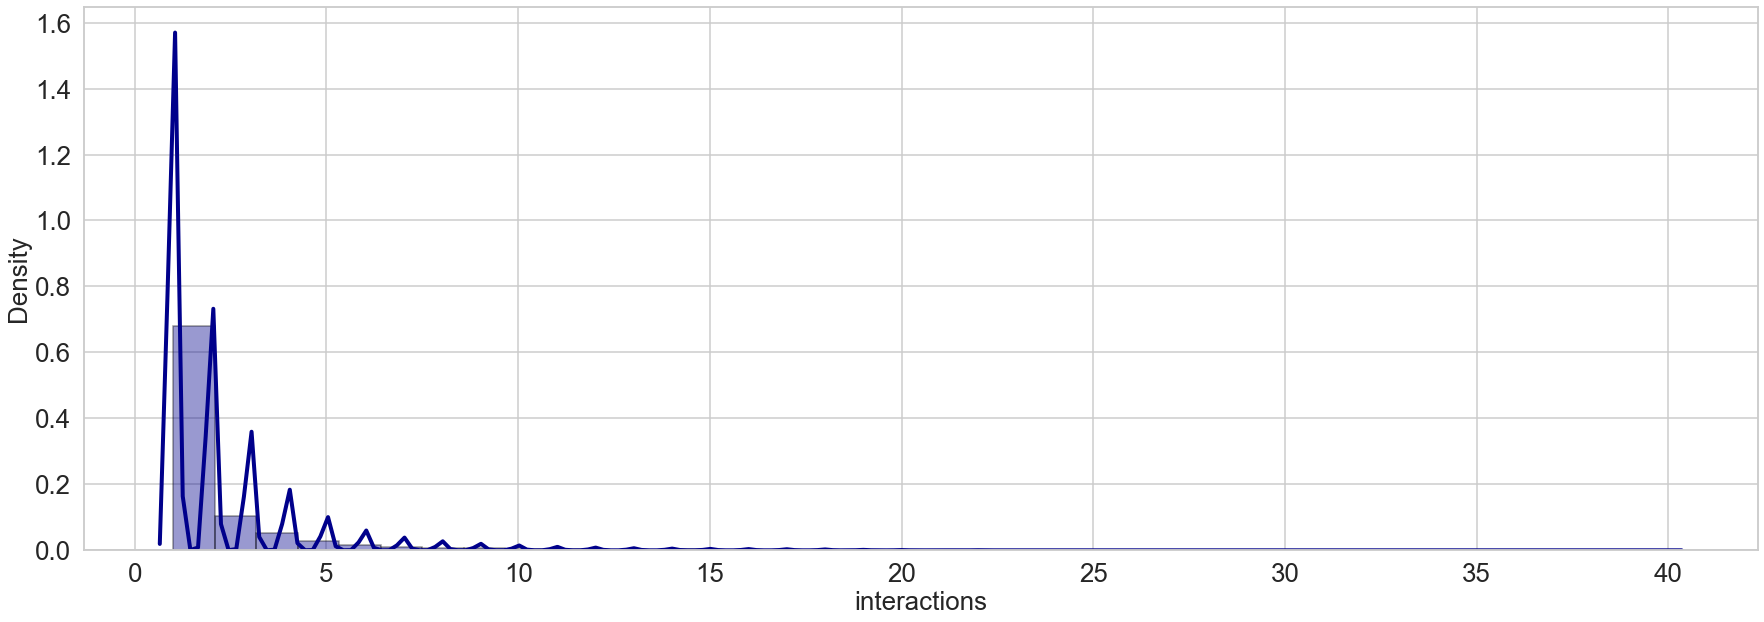

In [19]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
sns.distplot(cluster0['interactions'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});

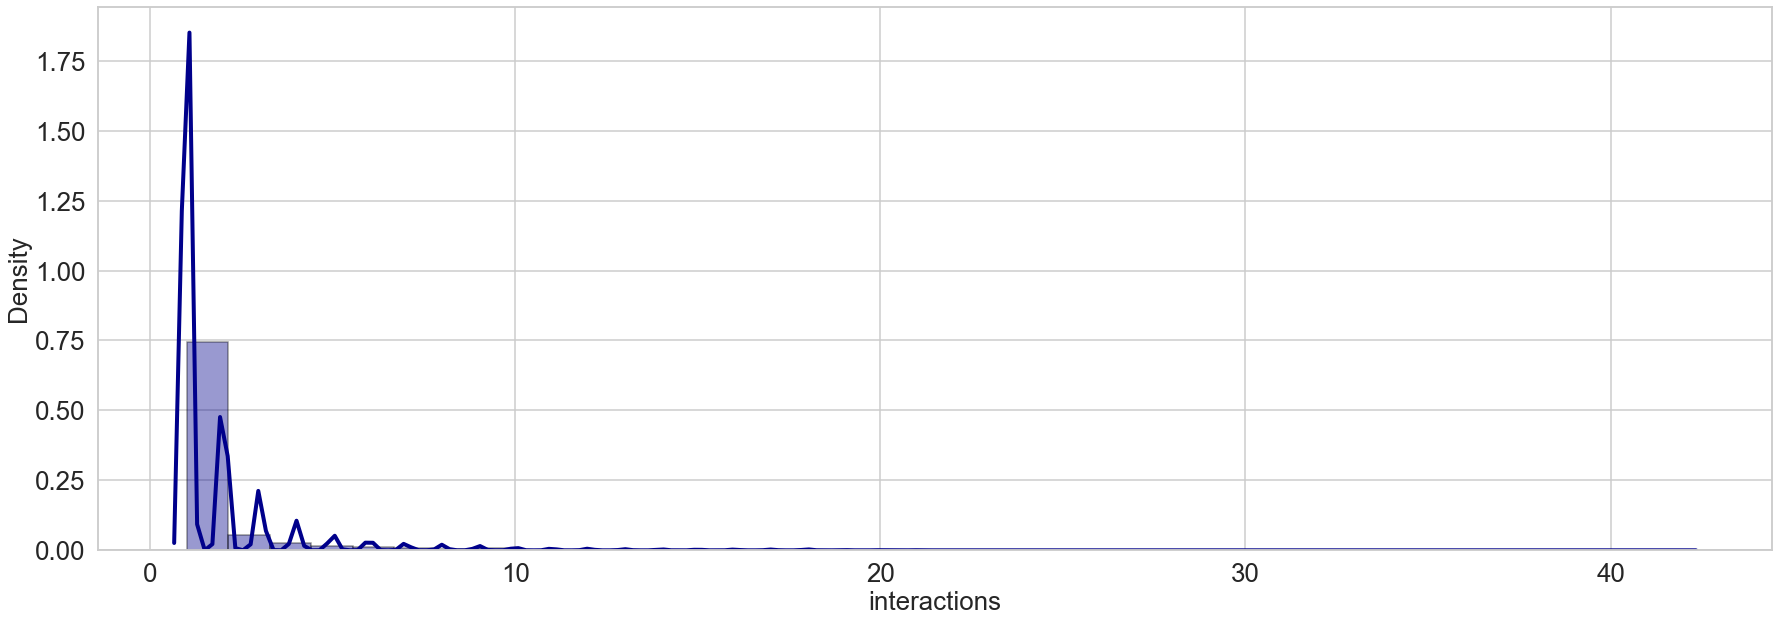

In [20]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
sns.distplot(cluster1['interactions'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});

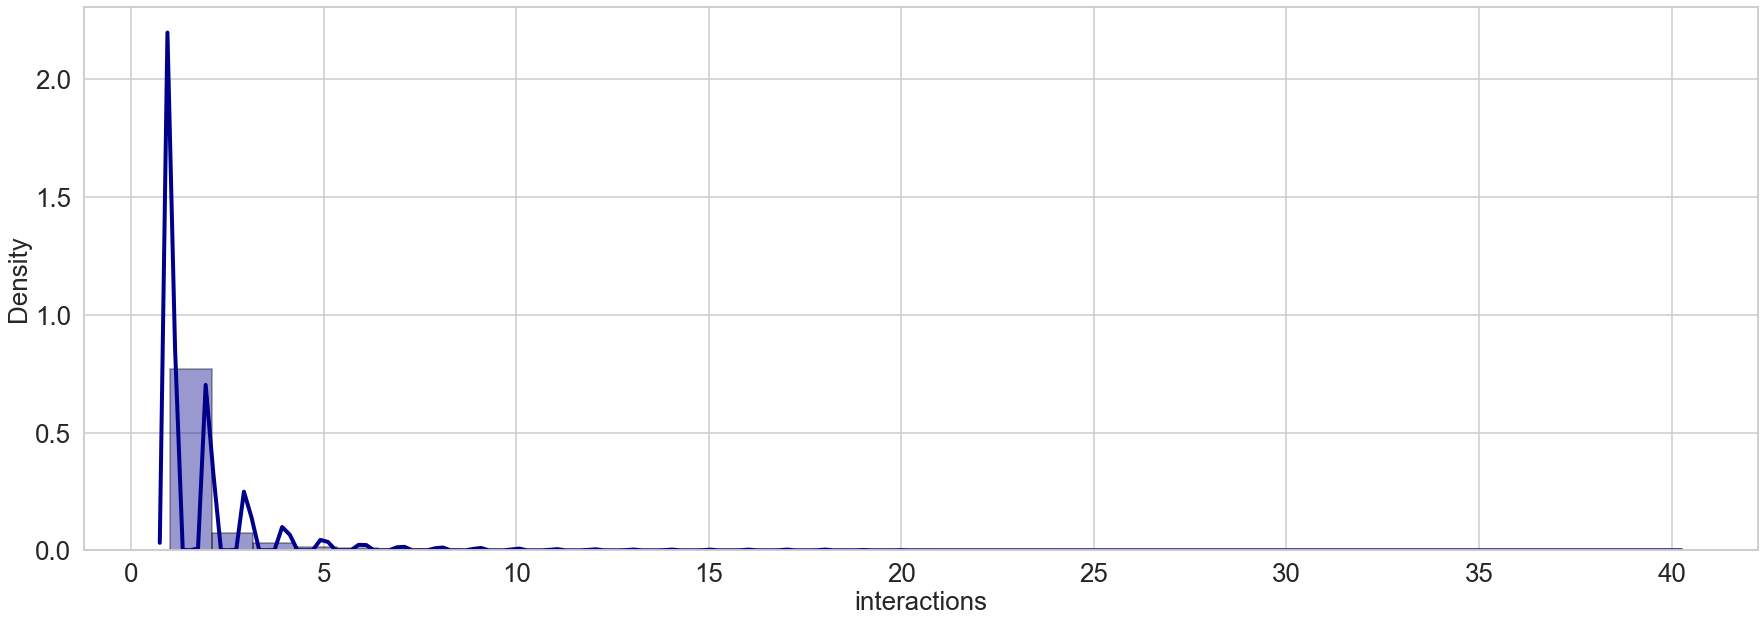

In [21]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
sns.distplot(cluster2['interactions'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});


In [22]:
def outliers(df):
    df = df.fillna(0)
    Q1= df.quantile(0.1)
    Q3 = df.quantile(0.9)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

upper0, lower0 = outliers(cluster0['interactions'])
upper1, lower1 = outliers(cluster1['interactions'])
upper2, lower2 = outliers(cluster2['interactions'])
print(upper0,lower0)
print(upper1,lower1)
print(upper2,lower2)

8.5 -3.5
6.0 -2.0
6.0 -2.0


In [23]:
conditions = [
    (cluster0['interactions'] < lower0) | (cluster0['interactions'] > upper0) ]
values = ['rebalancing']
cluster0['activity_type']= np.select(conditions, values,default = "rental")

conditions = [
    (cluster1['interactions'] < lower1) | (cluster1['interactions'] > upper1) ]
values = ['rebalancing']
cluster1['activity_type']= np.select(conditions, values,default = "rental")

conditions = [
    (cluster2['interactions'] < lower2) | (cluster2['interactions'] > upper2) ]
values = ['rebalancing']
cluster2['activity_type']= np.select(conditions, values,default = "rental")

In [24]:
c0_mean = cluster0.groupby(['Cluster','hour','minute'])['interactions'].mean().reset_index(name ='cluster_interaction_mean')
c0_mean['cluster_interaction_mean'] = c0_mean['cluster_interaction_mean'].apply(np.ceil)
c1_mean = cluster1.groupby(['Cluster','hour','minute'])['interactions'].mean().reset_index(name ='cluster_interaction_mean')
c1_mean['cluster_interaction_mean'] = c1_mean['cluster_interaction_mean'].apply(np.ceil)
c2_mean = cluster2.groupby(['Cluster','hour','minute'])['interactions'].mean().reset_index(name ='cluster_interaction_mean')
c2_mean['cluster_interaction_mean'] = c2_mean['cluster_interaction_mean'].apply(np.ceil)

cluster0 = pd.merge(cluster0, c0_mean, on = ['Cluster','hour','minute'], how = 'left')
cluster1 = pd.merge(cluster1, c1_mean, on = ['Cluster','hour','minute'], how = 'left')
cluster2 = pd.merge(cluster2, c2_mean, on = ['Cluster','hour','minute'], how = 'left')


In [25]:
conditions = [
    (cluster0['activity_type'] == "rebalancing"),
cluster0['activity_type'] == "rental"]
values = [cluster0['interactions'] - cluster0['cluster_interaction_mean'],0]
cluster0['rebalance'] = np.select(conditions, values)

conditions = [
    (cluster1['activity_type'] == "rebalancing"),
cluster1['activity_type'] == "rental"]
values = [cluster1['interactions'] - cluster1['cluster_interaction_mean'],0]
cluster1['rebalance'] = np.select(conditions, values)

conditions = [
    (cluster2['activity_type'] == "rebalancing"),
cluster2['activity_type'] == "rental"]
values = [cluster2['interactions'] - cluster2['cluster_interaction_mean'],0]
cluster2['rebalance'] = np.select(conditions, values)

In [26]:
all_cluster_data =  pd.concat([cluster0, cluster1,cluster2],  axis=0, ignore_index=True)

In [27]:
### Replacing the negative rebalance values to 0. As it is not practically possisble
conditions = [(all_cluster_data['activity_type'] == "rebalancing") & (all_cluster_data['rebalance'] <0)]
values = [0]
all_cluster_data['rebalance'] = np.select(conditions, values,default = all_cluster_data['rebalance'])

In [28]:
len(all_cluster_data)

7486942

In [29]:
all_cluster_data.columns
all_cluster_data.to_csv('/Users/sreevathsadb/Masters/Project/Data/Bike_Trips_2013_2018.csv', index=False)

In [30]:
selected_columns = ['id','name', 'timestamp','Cluster', 'total_bike_stands', 'available_bike_stands',
                    'available_bikes','bike_arr_dep','bike_arr', 'bike_dep', 'interactions','cluster_interaction_mean', 
                    'activity_type','rebalance','cluster_group','year', 'month', 'day', 'hour', 'minute', 
                    'weekday','day_type','holiday','season','wdsp','wdsp_classified','date_for_merge','latitude', 'longitude']
all_cluster_data = all_cluster_data[selected_columns]

### Trend analysis for bicycle journeys

### Bike Journeys Across all each stations per day 

In [31]:
bike_trips = all_cluster_data.copy()
bike_trips = bike_trips.groupby(['id','name','Cluster','year','month','day','season','weekday','holiday','latitude','longitude'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
bike_trips['trips'] = (bike_trips['interactions'])/2
bike_trips['transformed_trips'] = (abs((bike_trips['interactions'] - bike_trips['rebalance'])) + (abs(bike_trips['bike_arr_dep'])))/2
bike_trips['transformed_trips']  = bike_trips['transformed_trips'].apply(np.ceil)
#bike_trips.to_csv('/Users/sreevathsadb/Masters/Project/Data/Bike_Trips_Regression_Data/bike_trips_day_ML_13_18.csv', index=False)
bike_trips.head(5)

,id,name,Cluster,year,month,day,season,weekday,holiday,latitude,longitude,interactions,rebalance,bike_arr_dep,trips,transformed_trips
0,1,CLARENDON ROW,0,2014,10,16,Autumn,Thursday,casual_day,53.340883,-6.262542,174.0,15.0,0.0,87.0,80.0
1,1,CLARENDON ROW,0,2014,10,17,Autumn,Friday,casual_day,53.340883,-6.262542,140.0,0.0,6.0,70.0,73.0
2,1,CLARENDON ROW,0,2014,10,18,Autumn,Saturday,casual_day,53.340883,-6.262542,193.0,16.0,19.0,96.5,98.0
3,1,CLARENDON ROW,0,2014,10,19,Autumn,Sunday,casual_day,53.340883,-6.262542,134.0,17.0,-24.0,67.0,71.0
4,1,CLARENDON ROW,0,2014,10,20,Autumn,Monday,casual_day,53.340883,-6.262542,189.0,14.0,1.0,94.5,88.0


In [32]:
active_stations = all_cluster_data.copy()
trips_per_day = all_cluster_data.groupby(['year','month','day'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
trips_per_day['trips'] = trips_per_day['interactions']/2
trips_per_day['transformed_trips'] = (trips_per_day['interactions'] + abs(trips_per_day['bike_arr_dep']) - trips_per_day['rebalance'])/2
trips_per_day['transformed_trips']  = trips_per_day['transformed_trips'].apply(np.ceil)

active_stations = active_stations.groupby(['year','month','day'])['interactions'].count().reset_index(name ='activity_count')
idam_cdam_data = pd.merge(trips_per_day, active_stations, on = ['year','month','day'], how = 'inner')
idam_cdam_data['trips']  = idam_cdam_data['trips'].apply(np.ceil)
idam_cdam_data['trips_sq'] =  idam_cdam_data['trips'] * idam_cdam_data['trips']
idam_cdam_data['trips_sq_normalised'] = idam_cdam_data['trips_sq'] / idam_cdam_data['activity_count']
#idam_cdam_data.to_csv('/Users/sreevathsadb/Masters/Project/Data/Bike_Trips_Regression_Data/idam_cdam_data.csv', index=False)

Text(0.5, 1.0, 'Total Trips across Dublin Stations')

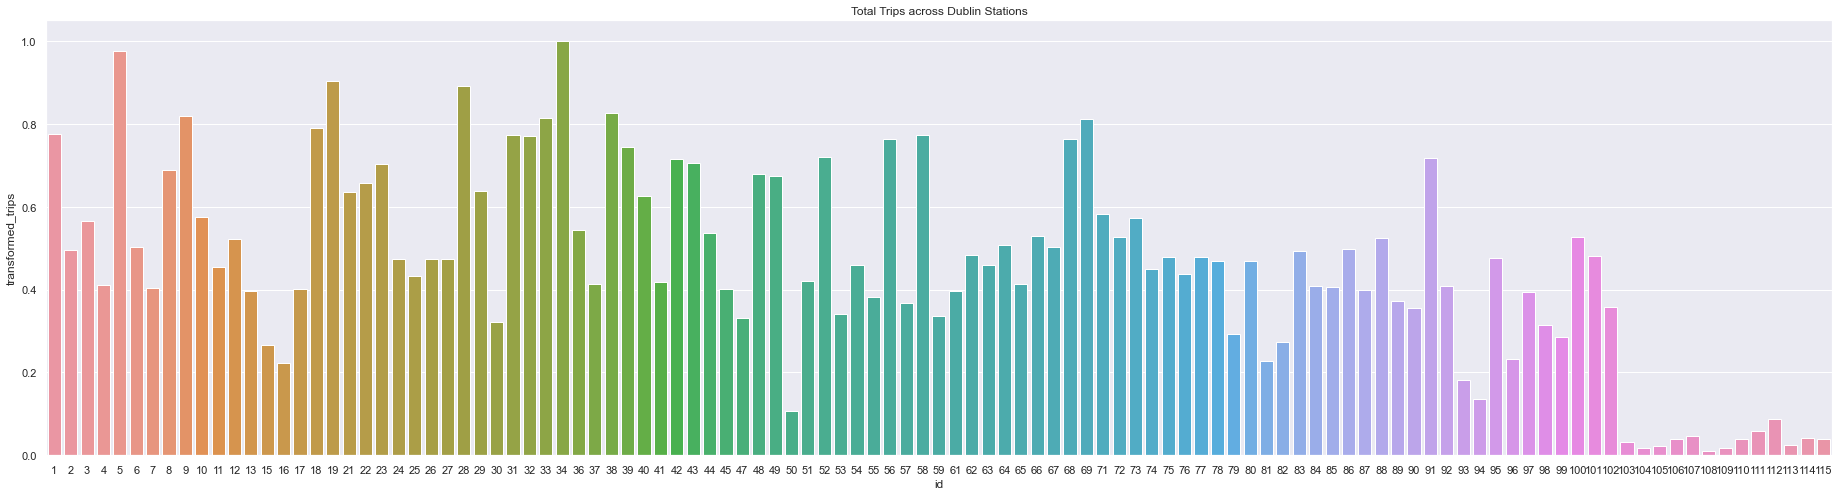

In [33]:

# Total Trips Vs Station
overall_trip_id = all_cluster_data.groupby(['id','Cluster'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
overall_trip_id['trips'] = (overall_trip_id['interactions'])/2
#overall_trip_id['trips']  = overall_trip_id['trips'].apply(np.ceil)
overall_trip_id['transformed_trips'] = (abs((overall_trip_id['interactions'] - overall_trip_id['rebalance'])) + (abs(overall_trip_id['bike_arr_dep'])))/2

overall_trip_id['transformed_trips'] = overall_trip_id['transformed_trips']/max(overall_trip_id['transformed_trips'])

sns.set(rc={'figure.figsize':(32,8)})
sns.barplot(x='id', y='transformed_trips', data=overall_trip_id, order=overall_trip_id['id']).set_title('Total Trips across Dublin Stations')


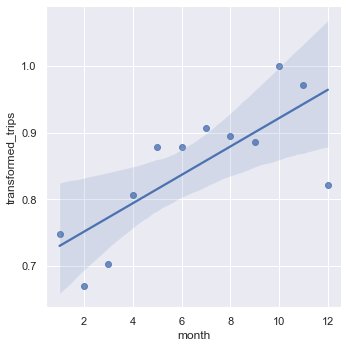

In [34]:
# Total Trips Vs Month
overall_trip_month = all_cluster_data.groupby(['month'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
overall_trip_month['trips'] = (overall_trip_month['interactions'])/2

overall_trip_month['transformed_trips'] = (abs((overall_trip_month['interactions'] - overall_trip_month['rebalance'])) + (abs(overall_trip_month['bike_arr_dep'])))/2

overall_trip_month['transformed_trips'] = overall_trip_month['transformed_trips']/max(overall_trip_month['transformed_trips'])

#sns.lineplot(x="month", y="transformed_trips", data=overall_trip_month)
sns.lmplot(x='month', y='transformed_trips', data=overall_trip_month)

#sns.jointplot(x='month', y='transformed_trips', data=overall_trip_month)
#plt.show()


No handles with labels found to put in legend.


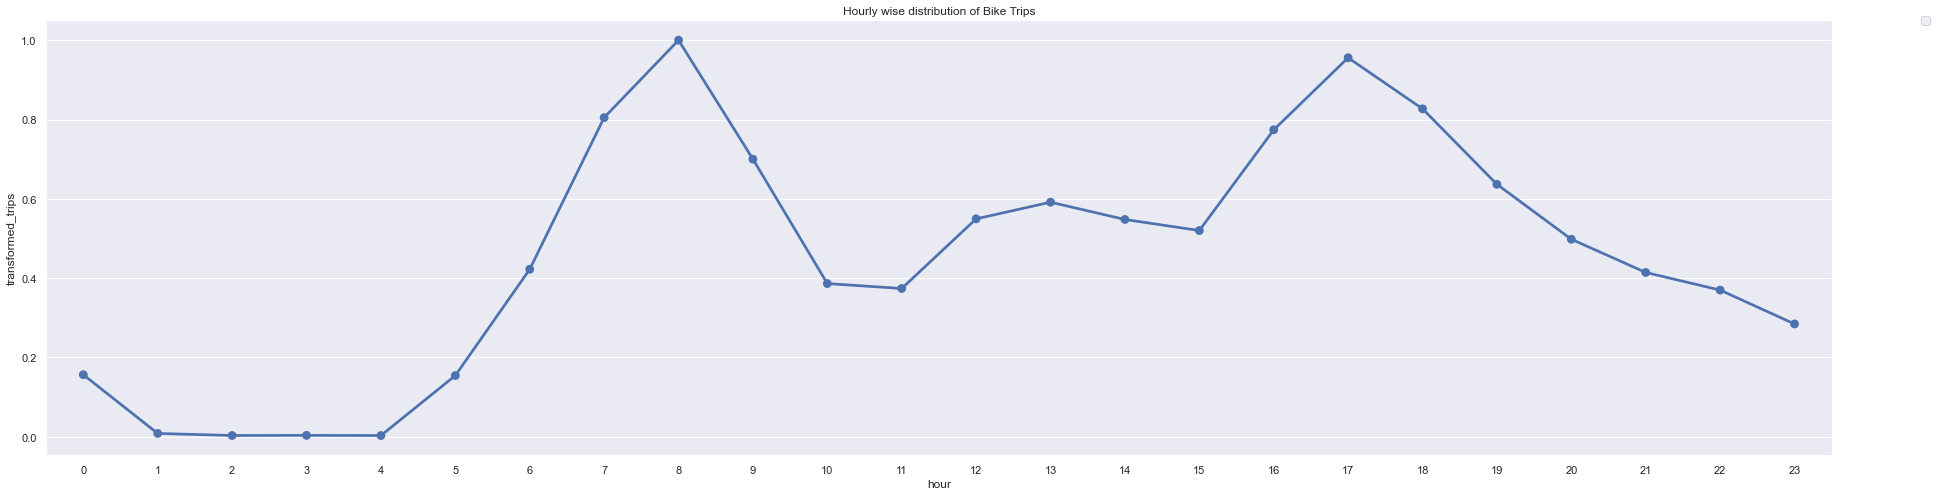

In [35]:
#Total Trips Vs Hour

overall_trip_cluster_group = all_cluster_data.groupby(['hour'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
overall_trip_cluster_group['trips'] = (overall_trip_cluster_group['interactions'])/2
overall_trip_cluster_group['transformed_trips'] = (abs((overall_trip_cluster_group['interactions'] - overall_trip_cluster_group['rebalance'])) + (abs(overall_trip_cluster_group['bike_arr_dep'])))/2

overall_trip_cluster_group['transformed_trips'] = overall_trip_cluster_group['transformed_trips']/max(overall_trip_cluster_group['transformed_trips'])
overall_trip_cluster_group


fig,ax = plt.subplots()
sns.pointplot(data=overall_trip_cluster_group[['hour',
                           'transformed_trips']],
              x='hour',
              y='transformed_trips',
              ax=ax)
ax.set(title="Hourly wise distribution of Bike Trips")

plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)

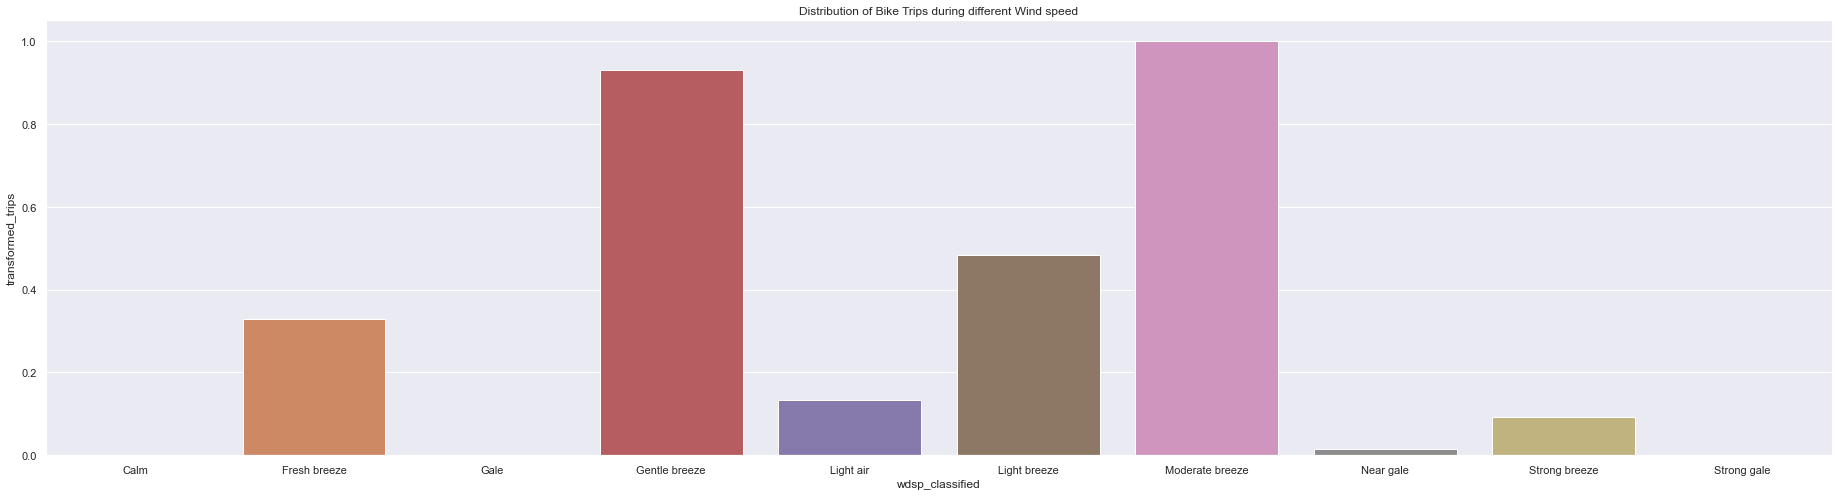

In [36]:
#Total Trips Vs Wind Classified
overall_trip_cluster_group = all_cluster_data.groupby(['wdsp_classified'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
overall_trip_cluster_group['trips'] = (overall_trip_cluster_group['interactions'])/2
overall_trip_cluster_group['transformed_trips'] = (abs((overall_trip_cluster_group['interactions'] - overall_trip_cluster_group['rebalance'])) + (abs(overall_trip_cluster_group['bike_arr_dep'])))/2

overall_trip_cluster_group['transformed_trips'] = overall_trip_cluster_group['transformed_trips']/max(overall_trip_cluster_group['transformed_trips'])

#overall_trip_cluster_group['transformed_trips'] = np.log2(overall_trip_cluster_group['transformed_trips'])/max(np.log2(overall_trip_cluster_group['transformed_trips']))
overall_trip_cluster_group

fig,ax = plt.subplots()

sns.barplot(x="wdsp_classified",y="transformed_trips",data=overall_trip_cluster_group)
ax.set(title="Distribution of Bike Trips during different Wind speed")
plt.show()


### Analyzing the hourly weekday trip trends for each station

[Text(0.5, 1.0, "Bike trips heat map for PRINCES STREET / O'CONNELL STREET")]

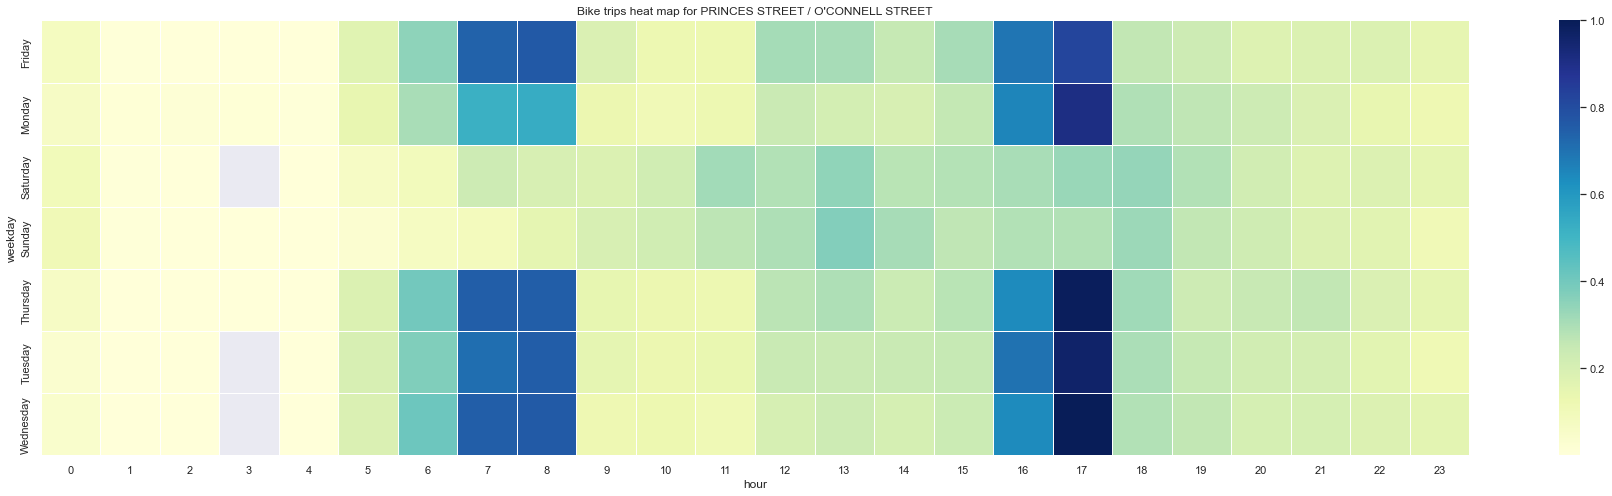

In [37]:
### GRAND CANAL DOCK

overall_trip_id = all_cluster_data[all_cluster_data['id'] == 69]
overall_trip_id = overall_trip_id.groupby(['id','weekday','hour'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
overall_trip_id

overall_trip_id['transformed_trips'] = (abs((overall_trip_id['interactions'] - overall_trip_id['rebalance'])) + (abs(overall_trip_id['bike_arr_dep'])))/2
overall_trip_id['transformed_trips']  = overall_trip_id['transformed_trips'].apply(np.ceil)
overall_trip_id['transformed_trips']  = overall_trip_id['transformed_trips']/overall_trip_id['transformed_trips'].max()

d = overall_trip_id.pivot("weekday", "hour", "transformed_trips")
#d = d.fillna(d.mean())
ax = sns.heatmap(d,linewidths=.5,cmap="YlGnBu")

ax.set(title="Bike trips heat map for PRINCES STREET / O'CONNELL STREET")

[Text(0.5, 1.0, "Bike trips heat map for PRINCES STREET / O'CONNELL STREET")]

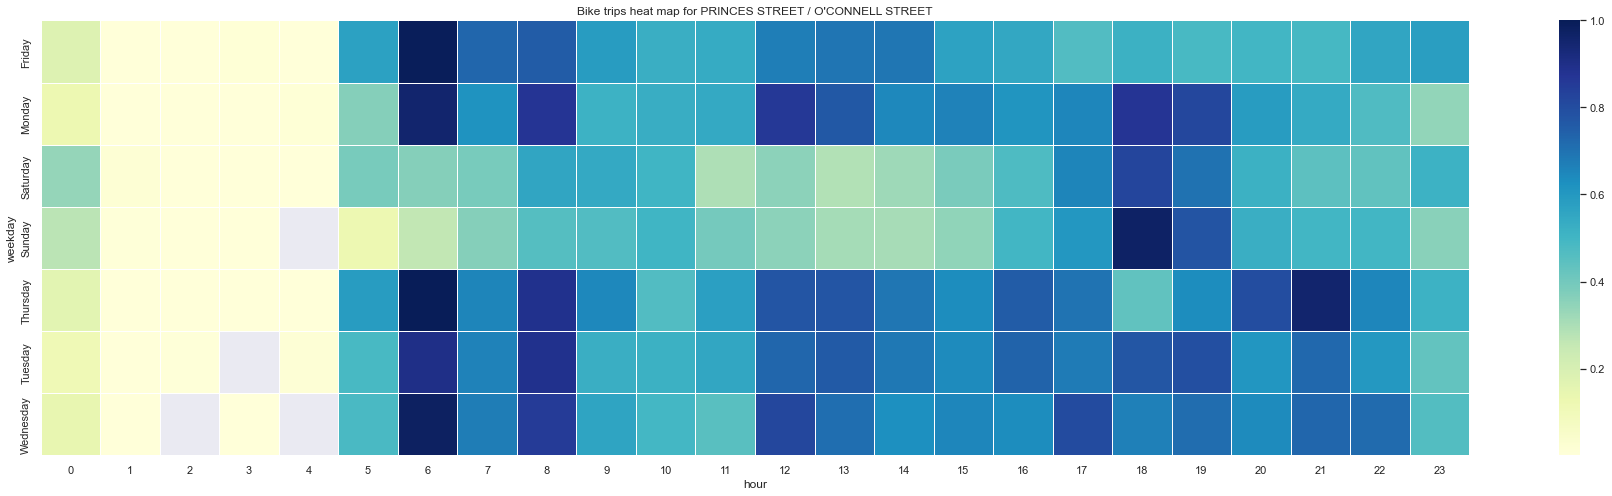

In [38]:
### PRINCES STREET / O'CONNELL STREET

overall_trip_id = all_cluster_data[all_cluster_data['id'] == 33]
overall_trip_id = overall_trip_id.groupby(['id','weekday','hour'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
overall_trip_id

overall_trip_id['transformed_trips'] = (abs((overall_trip_id['interactions'] - overall_trip_id['rebalance'])) + (abs(overall_trip_id['bike_arr_dep'])))/2
overall_trip_id['transformed_trips']  = overall_trip_id['transformed_trips'].apply(np.ceil)
overall_trip_id['transformed_trips']  = overall_trip_id['transformed_trips']/overall_trip_id['transformed_trips'].max()

d = overall_trip_id.pivot("weekday", "hour", "transformed_trips")
#d = d.fillna(d.mean())
ax = sns.heatmap(d,linewidths=.5,cmap="YlGnBu")

ax.set(title="Bike trips heat map for PRINCES STREET / O'CONNELL STREET")

[Text(0.5, 1.0, 'Bike trips heat map for EXCHEQUER STREET')]

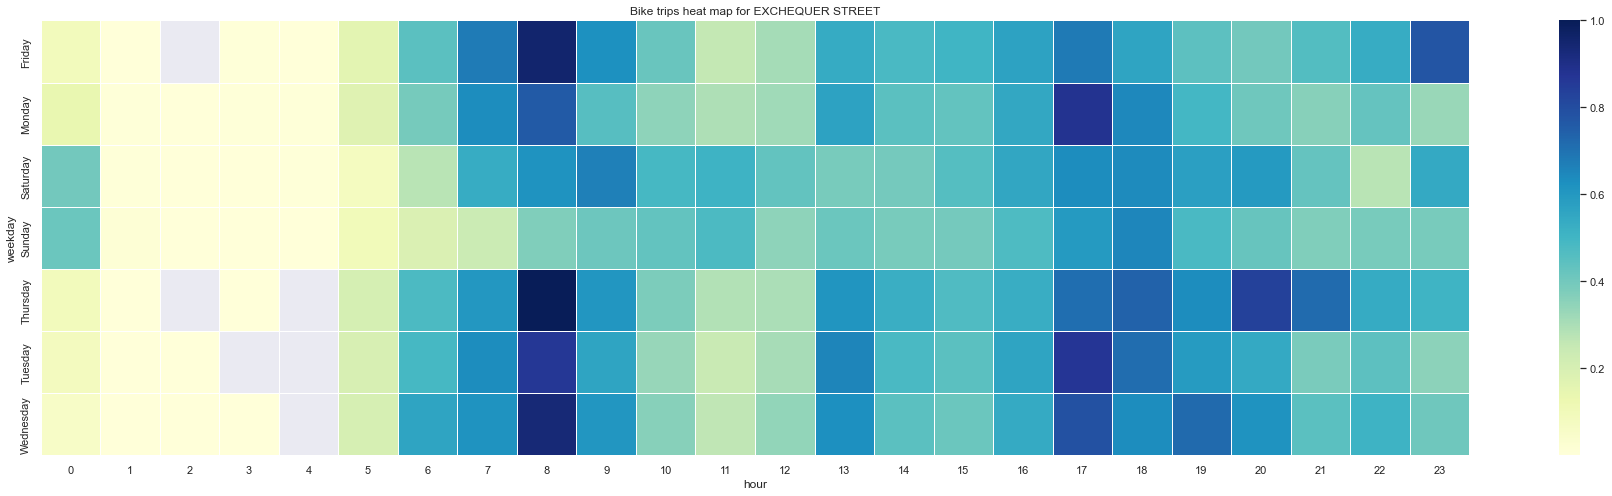

In [39]:
### EXCHEQUER STREET
overall_trip_id = all_cluster_data[all_cluster_data['id'] == 9]
overall_trip_id = overall_trip_id.groupby(['id','weekday','hour'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
overall_trip_id

overall_trip_id['transformed_trips'] = (abs((overall_trip_id['interactions'] - overall_trip_id['rebalance'])) + (abs(overall_trip_id['bike_arr_dep'])))/2
overall_trip_id['transformed_trips']  = overall_trip_id['transformed_trips'].apply(np.ceil)
overall_trip_id['transformed_trips']  = overall_trip_id['transformed_trips']/overall_trip_id['transformed_trips'].max()
d = overall_trip_id.pivot("weekday", "hour", "transformed_trips")
#d = d.fillna(d.mean())
ax = sns.heatmap(d,linewidths=.5,cmap="YlGnBu")

ax.set(title="Bike trips heat map for EXCHEQUER STREET")

[Text(0.5, 1.0, 'Bike trips heat map for HEUSTON STATION (CAR PARK)')]

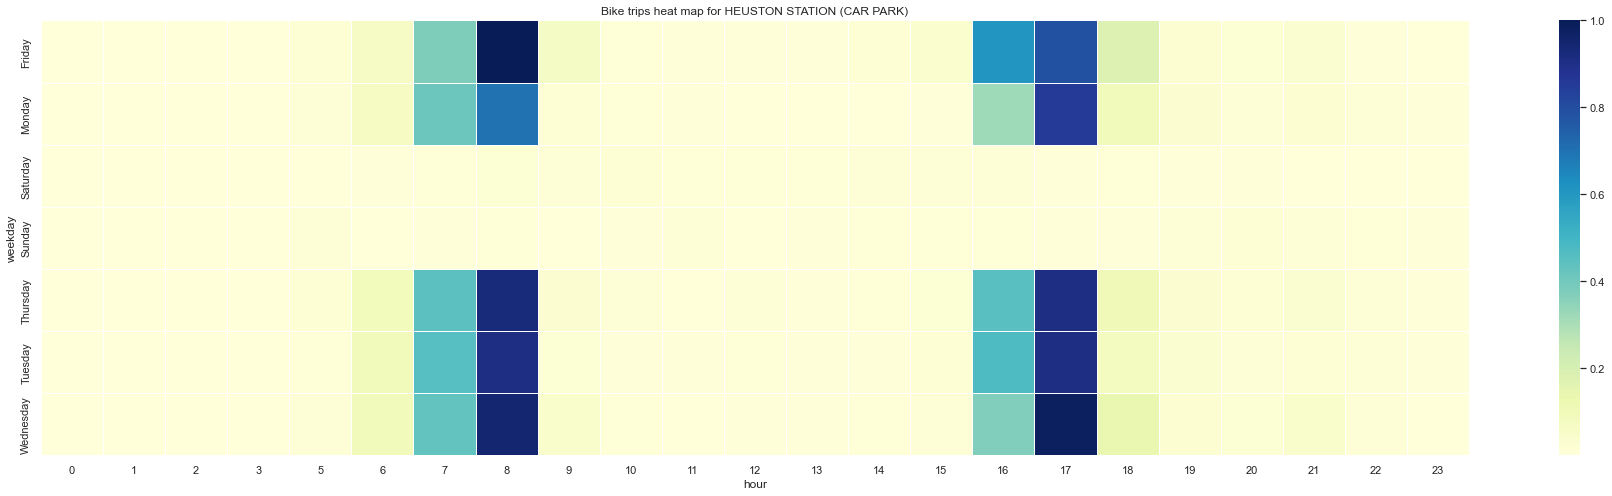

In [47]:
### HEUSTON STATION (CAR PARK)

overall_trip_id = all_cluster_data[all_cluster_data['id'] == 93]
overall_trip_id = overall_trip_id.groupby(['id','weekday','hour'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
overall_trip_id

overall_trip_id['transformed_trips'] = (abs((overall_trip_id['interactions'] - overall_trip_id['rebalance'])) + (abs(overall_trip_id['bike_arr_dep'])))/2
overall_trip_id['transformed_trips']  = overall_trip_id['transformed_trips'].apply(np.ceil)
overall_trip_id['transformed_trips']  = overall_trip_id['transformed_trips']/overall_trip_id['transformed_trips'].max()
d = overall_trip_id.pivot("weekday", "hour", "transformed_trips")
d = d.fillna(d.mean())
ax = sns.heatmap(d,linewidths=.5,cmap="YlGnBu")

ax.set(title="Bike trips heat map for HEUSTON STATION (CAR PARK)")

[Text(0.5, 1.0, "Bike trips heat map for PRINCES STREET / O'CONNELL STREET")]

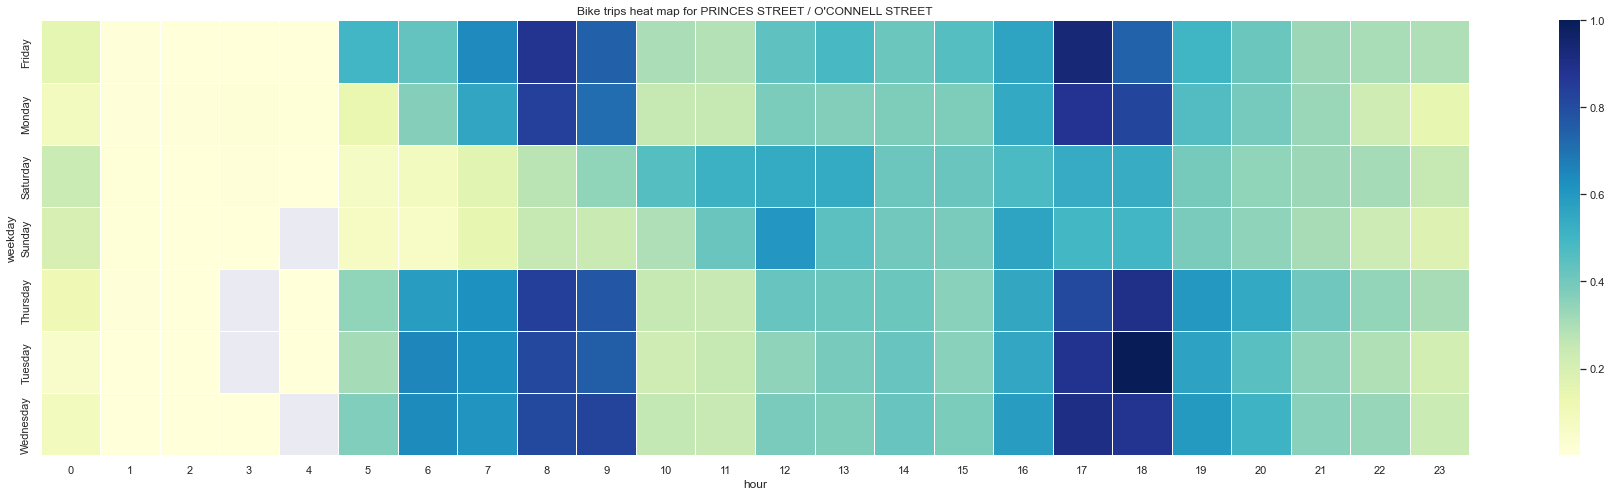

In [46]:
### SOUTH DOCK ROAD

overall_trip_id = all_cluster_data[all_cluster_data['id'] == 91]
overall_trip_id = overall_trip_id.groupby(['id','weekday','hour'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
overall_trip_id

overall_trip_id['transformed_trips'] = (abs((overall_trip_id['interactions'] - overall_trip_id['rebalance'])) + (abs(overall_trip_id['bike_arr_dep'])))/2
overall_trip_id['transformed_trips']  = overall_trip_id['transformed_trips'].apply(np.ceil)
overall_trip_id['transformed_trips']  = overall_trip_id['transformed_trips']/overall_trip_id['transformed_trips'].max()

d = overall_trip_id.pivot("weekday", "hour", "transformed_trips")
#d = d.fillna(d.mean())
ax = sns.heatmap(d,linewidths=.5,cmap="YlGnBu")

ax.set(title="Bike trips heat map for SOUTH DOCK ROAD")

In [41]:
rebalance_analysis = all_cluster_data[all_cluster_data['year'] == 2018]
rebalance_analysis = rebalance_analysis.groupby(['activity_type'])['rebalance'].count().reset_index()
rebalance_analysis['proportion(%)'] = rebalance_analysis['rebalance']/sum(rebalance_analysis['rebalance'])*100
rebalance_analysis[['activity_type','proportion(%)']]

,activity_type,proportion(%)
0,rebalancing,2.530724
1,rental,97.469276
